<a href="https://colab.research.google.com/github/connorvelliott/Machine-Learning_Motion-Tracking/blob/main/Aero_689_HW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Aero 689 Assignment 2 - Connor Elliott

###Imports for Both Problems

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import time

##Approach 1 - Linear Combination of Basis Functions

###Basis Functions

In [ ]:
def polynomial_basis_functions(t, order):
    return np.array([t**i for i in range(order)])

def bspline_basis_functions(t, order, num_control_points):
  knots = np.linspace(0,1,num_control_points + order + 1)
  spl = BSpline(knots,np.eye(num_control_points),order)
  return spl(t)

def radial_basis_functions(t,num_radial_centers):
  centers = np.linspace(0,1,num_radial_centers)
  widths = 1.0 / (num_radial_centers - 1)
  basis_funcs = np.exp(-(t - centers)**2 / (2 * widths**2))
  return basis_funcs

###Dynamics, Cost, Constraint, and Trajectory Simulation Functions

In [ ]:
def aircraft_dynamics(t, state, control):
    x, y, theta, x_dot, y_dot, theta_dot = state
    T, M = control
    m = 1  # Mass of the aircraft
    I_z = 1  # Moment of inertia

    x_ddot = T * np.cos(theta) / m
    y_ddot = T * np.sin(theta) / m
    theta_ddot = M / I_z

    return [x_dot, y_dot, theta_dot, x_ddot, y_ddot, theta_ddot]

def cost_function(control_traj, *args):
    initial_state, final_state, num_segments, basis_functions, obstacles = args
    dt = 1.0 / num_segments

    quad_cost = 0
    obs_cost = 0

    for i in range(num_segments):
        control = control_traj[i * 2: (i + 1) * 2]
        state = initial_state if i == 0 else next_state
        next_state = state + np.array(aircraft_dynamics(i * dt, state, control)) * dt

        # Compute segment cost (e.g., quadratic cost)
        segment_cost = np.sum(np.square(control))
        quad_cost += segment_cost

        # Check for collision with obstacles
        for obstacle in obstacles:
            obs_x, obs_y, obs_r = obstacle
            dist_squared = (next_state[0] - obs_x)**2 + (next_state[1] - obs_y)**2
            combined_radius_squared = (obs_r + 0.5)**2
            too_close = dist_squared - combined_radius_squared
            if too_close <= 6:
                obs_cost += -1*too_close  # Penalize collisions

    # Add terminal cost (e.g., final state error)
    terminal_cost = np.sum(np.square(final_state - next_state))

    total_cost = quad_cost + 1000*obs_cost + 10*terminal_cost

    return total_cost

def final_state_constraint(control_traj, *args):
    initial_state, final_state, num_segments, basis_functions, obstacles = args
    dt = 1.0 / num_segments
    state = initial_state

    for i in range(num_segments):
        control = control_traj[i * 2: (i + 1) * 2]
        state = state + np.array(aircraft_dynamics(i * dt, state, control)) * dt

    # Ensure final state condition is met
    return final_state - state

def simulate_trajectory(initial_state, optimal_control_traj, num_segments):
    dt = 1.0 / num_segments
    state = initial_state
    states = [initial_state]

    for i in range(num_segments):
        control = optimal_control_traj[i]
        state = state + np.array(aircraft_dynamics(i * dt, state, control)) * dt
        states.append(state)

    return np.array(states)

###Initial State, Final State, and Obstacle Locations

In [ ]:
initial_state = np.array([0, 0, 0, 0, 0, 0])
final_state = np.array([10, 10, np.pi/2, 0, 0, 0])
obstacles = [(4, 1, 1.0), (7, 7, 1.25), (7,3,1), (2,3,0.75), (5,10,1.5),(4,6,0.5)]

###Polynomial Solution - 3 Basis Functions

Runtime: 82.04452 seconds


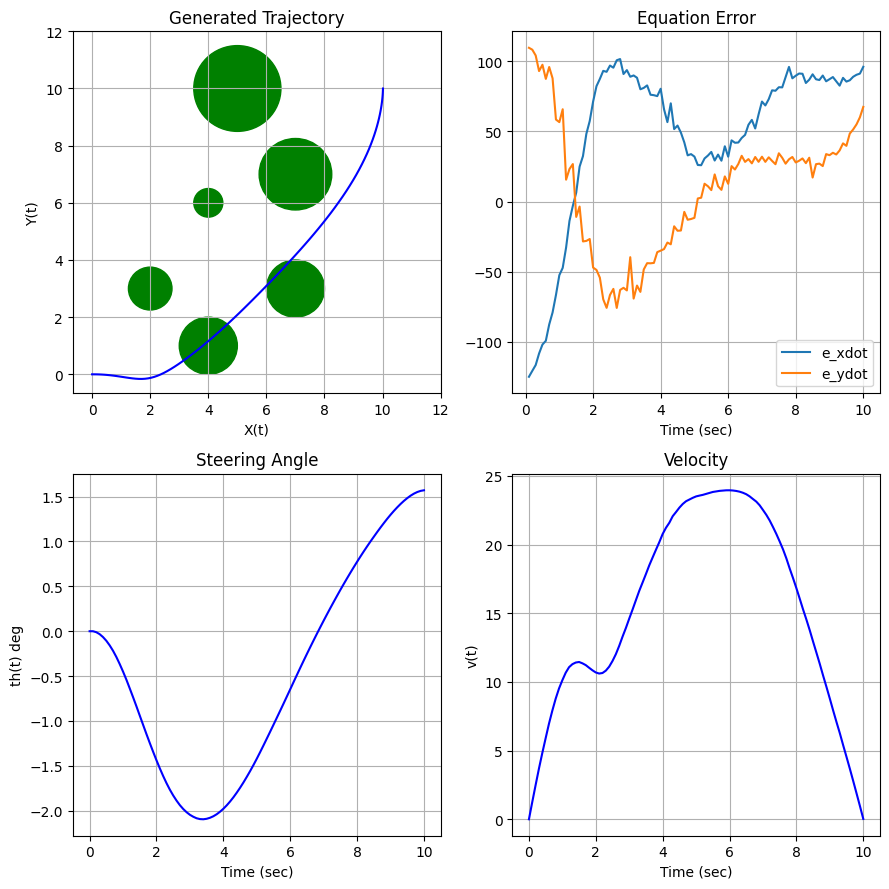

In [ ]:
# Define number of segments and basis functions
num_segments = 100
num_basis_functions = 3

start_time = time.time()

# Generate basis functions for each segment
basis_functions = [polynomial_basis_functions(i * (1.0 / num_segments), num_basis_functions) for i in range(num_segments)]

# Flatten the basis functions into a single vector for optimization
basis_functions_flat = np.concatenate(basis_functions)

# Initial guess for control trajectories
initial_guess = np.random.randn(num_segments * 2)

# Set up optimization problem with constraints
args = (initial_state, final_state, num_segments, basis_functions_flat, obstacles)
constraints = [{'type': 'eq', 'fun': final_state_constraint, 'args': args}]
result = minimize(cost_function, initial_guess, args=args, method='SLSQP', constraints=constraints)

# Extract optimal control trajectories from the result
optimal_control_traj = result.x.reshape(num_segments, 2)

end_time = time.time()
runtime = end_time - start_time
print("Runtime: {:.5f} seconds".format(runtime))

# Simulate trajectory using optimal control trajectory
simulated_states = simulate_trajectory(initial_state, optimal_control_traj, num_segments)

# Extract variables for plotting
X = simulated_states[:, 0]
Y = simulated_states[:, 1]
theta = simulated_states[:, 2]
xdot = simulated_states[:, 3]
ydot = simulated_states[:, 4]
theta_dot = simulated_states[:, 5]

# Time array
time_plot = np.linspace(0, 10, num_segments + 1)

# Plotting
plt.figure(figsize=(9, 9))

# 1. Plot trajectory Y(t) versus X(t)
plt.subplot(2, 2, 1)
plt.plot(X, Y, '-b')
plt.xlabel('X(t)')
plt.ylabel('Y(t)')
plt.title('Generated Trajectory')
minobs = 1000
maxobs = 0
for obstacle in obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='green')
    plt.gca().add_patch(circle)
    if obstacle[0]-obstacle[2] < minobs:
      minobs = obstacle[0]-obstacle[2]
    elif obstacle[1]-obstacle[2] < minobs:
      minobs = obstacle[1]-obstacle[2]
    if obstacle[0]+obstacle[2] > maxobs:
      maxobs = obstacle[0]+obstacle[2]
    elif obstacle[1]+obstacle[2] > maxobs:
      maxobs = obstacle[1]+obstacle[2]
minlist = [min(X),min(Y),minobs]
maxlist = [max(X),max(Y),maxobs]
plt.xlim(min(minlist)-.5, max(maxlist)+.5)
plt.ylim(min(minlist)-.5, max(maxlist)+.5)
plt.grid(True)

# 2. Plot equation error xdot as a function of time
plt.subplot(2, 2, 2)
plt.plot(time_plot[1:], xdot[1:] - optimal_control_traj[:, 0], label = 'e_xdot')
plt.plot(time_plot[1:], ydot[1:] - optimal_control_traj[:, 1], label = 'e_ydot')
plt.xlabel('Time (sec)')
plt.title('Equation Error')
plt.legend()
plt.grid(True)

# 3. Plot steering angle theta as a function of time
plt.subplot(2, 2, 3)
plt.plot(time_plot, theta, '-b')
plt.xlabel('Time (sec)')
plt.ylabel('th(t) deg')
plt.title('Steering Angle')
plt.grid(True)

# 4. Plot velocity as a function of time
plt.subplot(2, 2, 4)
plt.plot(time_plot, np.sqrt(xdot**2 + ydot**2), '-b')
plt.xlabel('Time (sec)')
plt.ylabel('v(t)')
plt.title('Velocity')
plt.grid(True)

plt.tight_layout()
plt.show()


###Polynomial Solution - 5 Basis Functions

Runtime: 69.72401 seconds


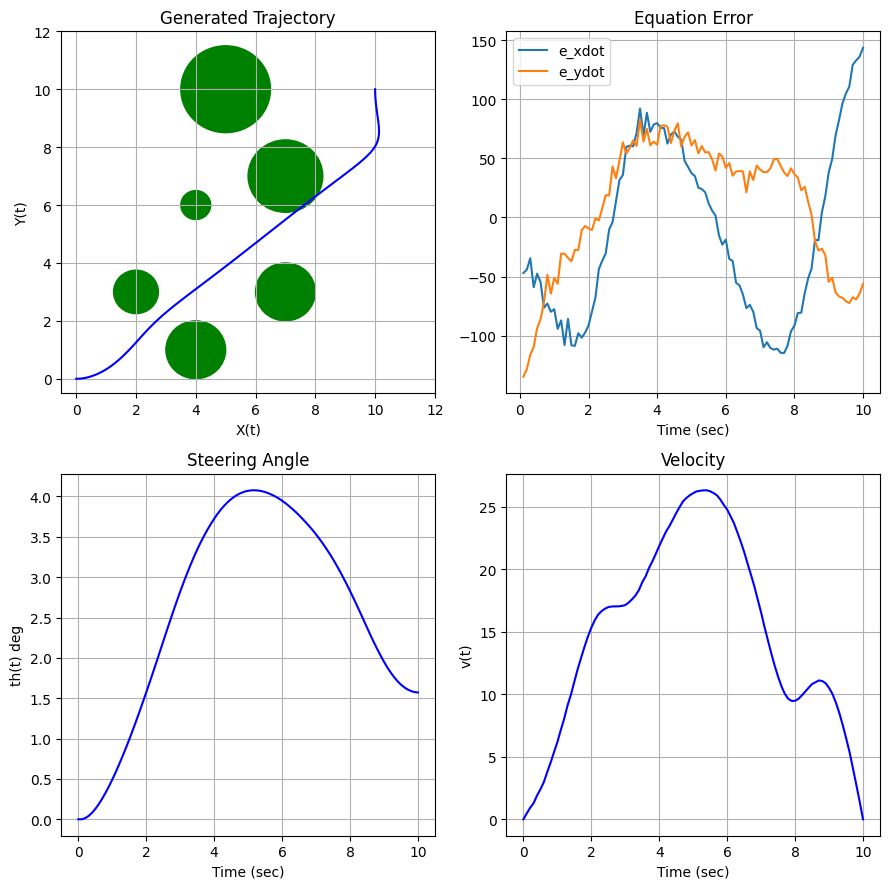

In [ ]:
# Define number of segments and basis functions
num_segments = 100
num_basis_functions = 5

start_time = time.time()

# Generate basis functions for each segment
basis_functions = [polynomial_basis_functions(i * (1.0 / num_segments), num_basis_functions) for i in range(num_segments)]

# Flatten the basis functions into a single vector for optimization
basis_functions_flat = np.concatenate(basis_functions)

# Initial guess for control trajectories
initial_guess = np.random.randn(num_segments * 2)

# Set up optimization problem with constraints
args = (initial_state, final_state, num_segments, basis_functions_flat, obstacles)
constraints = [{'type': 'eq', 'fun': final_state_constraint, 'args': args}]
result = minimize(cost_function, initial_guess, args=args, method='SLSQP', constraints=constraints)

# Extract optimal control trajectories from the result
optimal_control_traj = result.x.reshape(num_segments, 2)

end_time = time.time()
runtime = end_time - start_time
print("Runtime: {:.5f} seconds".format(runtime))

# Simulate trajectory using optimal control trajectory
simulated_states = simulate_trajectory(initial_state, optimal_control_traj, num_segments)

# Extract variables for plotting
X = simulated_states[:, 0]
Y = simulated_states[:, 1]
theta = simulated_states[:, 2]
xdot = simulated_states[:, 3]
ydot = simulated_states[:, 4]
theta_dot = simulated_states[:, 5]

# Time array
time_plot = np.linspace(0, 10, num_segments + 1)

# Plotting
plt.figure(figsize=(9, 9))

# 1. Plot trajectory Y(t) versus X(t)
plt.subplot(2, 2, 1)
plt.plot(X, Y, '-b')
plt.xlabel('X(t)')
plt.ylabel('Y(t)')
plt.title('Generated Trajectory')
minobs = 1000
maxobs = 0
for obstacle in obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='green')
    plt.gca().add_patch(circle)
    if obstacle[0]-obstacle[2] < minobs:
      minobs = obstacle[0]-obstacle[2]
    elif obstacle[1]-obstacle[2] < minobs:
      minobs = obstacle[1]-obstacle[2]
    if obstacle[0]+obstacle[2] > maxobs:
      maxobs = obstacle[0]+obstacle[2]
    elif obstacle[1]+obstacle[2] > maxobs:
      maxobs = obstacle[1]+obstacle[2]
minlist = [min(X),min(Y),minobs]
maxlist = [max(X),max(Y),maxobs]
plt.xlim(min(minlist)-.5, max(maxlist)+.5)
plt.ylim(min(minlist)-.5, max(maxlist)+.5)
plt.grid(True)

# 2. Plot equation error xdot as a function of time
plt.subplot(2, 2, 2)
plt.plot(time_plot[1:], xdot[1:] - optimal_control_traj[:, 0], label = 'e_xdot')
plt.plot(time_plot[1:], ydot[1:] - optimal_control_traj[:, 1], label = 'e_ydot')
plt.xlabel('Time (sec)')
plt.title('Equation Error')
plt.legend()
plt.grid(True)

# 3. Plot steering angle theta as a function of time
plt.subplot(2, 2, 3)
plt.plot(time_plot, theta, '-b')
plt.xlabel('Time (sec)')
plt.ylabel('th(t) deg')
plt.title('Steering Angle')
plt.grid(True)

# 4. Plot velocity as a function of time
plt.subplot(2, 2, 4)
plt.plot(time_plot, np.sqrt(xdot**2 + ydot**2), '-b')
plt.xlabel('Time (sec)')
plt.ylabel('v(t)')
plt.title('Velocity')
plt.grid(True)

plt.tight_layout()
plt.show()

###B-spline Solution - 3 Basis Functions

Runtime: 66.59842 seconds


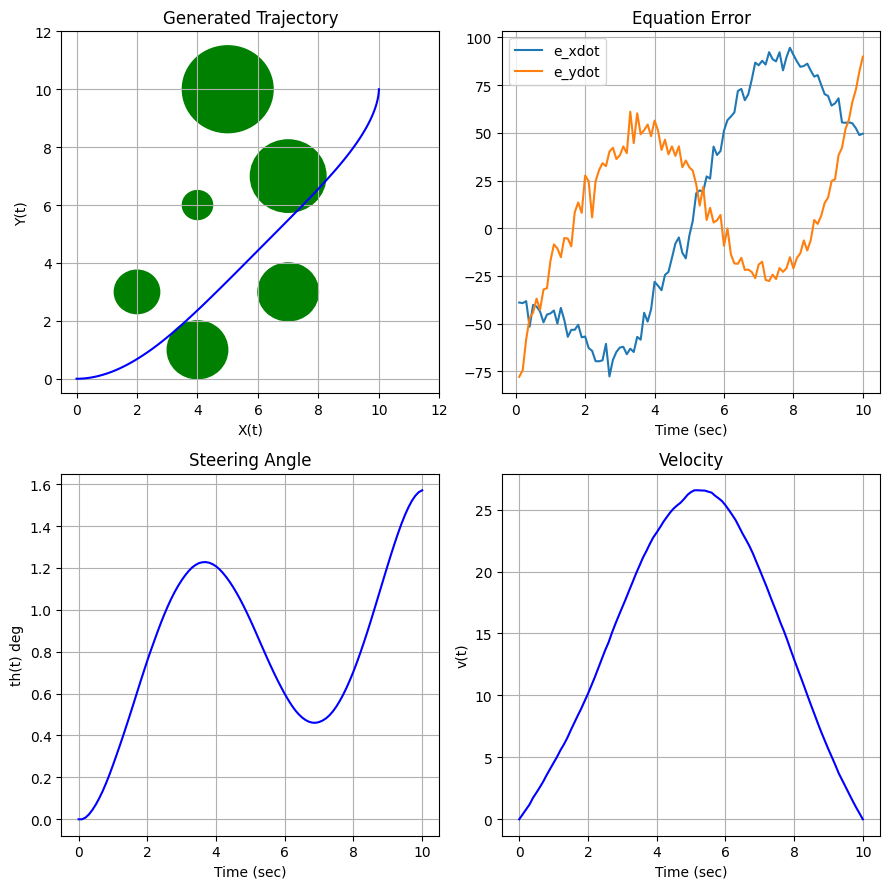

In [ ]:
# Define number of segments and basis functions
num_segments = 100
num_basis_functions = 3

start_time = time.time()

# Generate basis functions for each segment
basis_functions = [bspline_basis_functions(i * (1.0 / num_segments), 2, num_basis_functions+2) for i in range(num_segments)]

# Flatten the basis functions into a single vector for optimization
basis_functions_flat = np.concatenate(basis_functions)

# Initial guess for control trajectories
initial_guess = np.random.randn(num_segments * 2)

# Set up optimization problem with constraints
args = (initial_state, final_state, num_segments, basis_functions_flat, obstacles)
constraints = [{'type': 'eq', 'fun': final_state_constraint, 'args': args}]
result = minimize(cost_function, initial_guess, args=args, method='SLSQP', constraints=constraints)

# Extract optimal control trajectories from the result
optimal_control_traj = result.x.reshape(num_segments, 2)

end_time = time.time()
runtime = end_time - start_time
print("Runtime: {:.5f} seconds".format(runtime))

# Simulate trajectory using optimal control trajectory
simulated_states = simulate_trajectory(initial_state, optimal_control_traj, num_segments)

# Extract variables for plotting
X = simulated_states[:, 0]
Y = simulated_states[:, 1]
theta = simulated_states[:, 2]
xdot = simulated_states[:, 3]
ydot = simulated_states[:, 4]
theta_dot = simulated_states[:, 5]

# Time array
time_plot = np.linspace(0, 10, num_segments + 1)

# Plotting
plt.figure(figsize=(9, 9))

# 1. Plot trajectory Y(t) versus X(t)
plt.subplot(2, 2, 1)
plt.plot(X, Y, '-b')
plt.xlabel('X(t)')
plt.ylabel('Y(t)')
plt.title('Generated Trajectory')
minobs = 1000
maxobs = 0
for obstacle in obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='green')
    plt.gca().add_patch(circle)
    if obstacle[0]-obstacle[2] < minobs:
      minobs = obstacle[0]-obstacle[2]
    elif obstacle[1]-obstacle[2] < minobs:
      minobs = obstacle[1]-obstacle[2]
    if obstacle[0]+obstacle[2] > maxobs:
      maxobs = obstacle[0]+obstacle[2]
    elif obstacle[1]+obstacle[2] > maxobs:
      maxobs = obstacle[1]+obstacle[2]
minlist = [min(X),min(Y),minobs]
maxlist = [max(X),max(Y),maxobs]
plt.xlim(min(minlist)-.5, max(maxlist)+.5)
plt.ylim(min(minlist)-.5, max(maxlist)+.5)
plt.grid(True)

# 2. Plot equation error xdot as a function of time
plt.subplot(2, 2, 2)
plt.plot(time_plot[1:], xdot[1:] - optimal_control_traj[:, 0], label = 'e_xdot')
plt.plot(time_plot[1:], ydot[1:] - optimal_control_traj[:, 1], label = 'e_ydot')
plt.xlabel('Time (sec)')
plt.title('Equation Error')
plt.legend()
plt.grid(True)

# 3. Plot steering angle theta as a function of time
plt.subplot(2, 2, 3)
plt.plot(time_plot, theta, '-b')
plt.xlabel('Time (sec)')
plt.ylabel('th(t) deg')
plt.title('Steering Angle')
plt.grid(True)

# 4. Plot velocity as a function of time
plt.subplot(2, 2, 4)
plt.plot(time_plot, np.sqrt(xdot**2 + ydot**2), '-b')
plt.xlabel('Time (sec)')
plt.ylabel('v(t)')
plt.title('Velocity')
plt.grid(True)

plt.tight_layout()
plt.show()


###B-spline Solution - 5 Basis Functions

Runtime: 67.15690 seconds


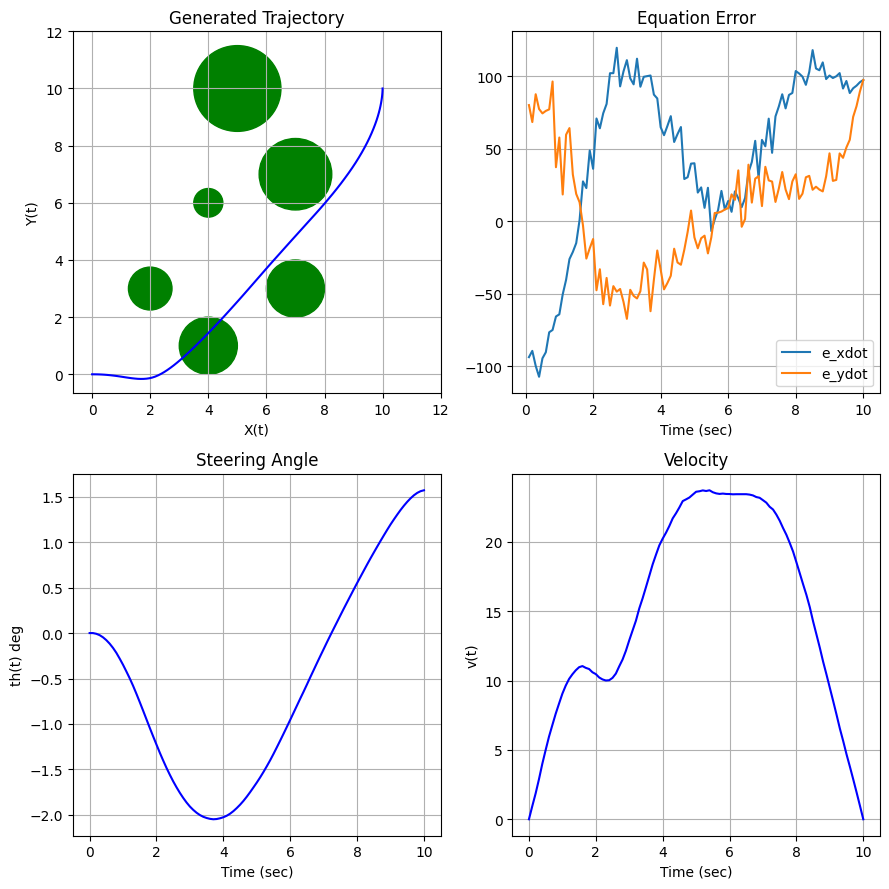

In [ ]:
# Define number of segments and basis functions
num_segments = 100
num_basis_functions = 5

start_time = time.time()

# Generate basis functions for each segment
basis_functions = [bspline_basis_functions(i * (1.0 / num_segments), 2, num_basis_functions+2) for i in range(num_segments)]

# Flatten the basis functions into a single vector for optimization
basis_functions_flat = np.concatenate(basis_functions)

# Initial guess for control trajectories
initial_guess = np.random.randn(num_segments * 2)

# Set up optimization problem with constraints
args = (initial_state, final_state, num_segments, basis_functions_flat, obstacles)
constraints = [{'type': 'eq', 'fun': final_state_constraint, 'args': args}]
result = minimize(cost_function, initial_guess, args=args, method='SLSQP', constraints=constraints)

# Extract optimal control trajectories from the result
optimal_control_traj = result.x.reshape(num_segments, 2)

end_time = time.time()
runtime = end_time - start_time
print("Runtime: {:.5f} seconds".format(runtime))

# Simulate trajectory using optimal control trajectory
simulated_states = simulate_trajectory(initial_state, optimal_control_traj, num_segments)

# Extract variables for plotting
X = simulated_states[:, 0]
Y = simulated_states[:, 1]
theta = simulated_states[:, 2]
xdot = simulated_states[:, 3]
ydot = simulated_states[:, 4]
theta_dot = simulated_states[:, 5]

# Time array
time_plot = np.linspace(0, 10, num_segments + 1)

# Plotting
plt.figure(figsize=(9, 9))

# 1. Plot trajectory Y(t) versus X(t)
plt.subplot(2, 2, 1)
plt.plot(X, Y, '-b')
plt.xlabel('X(t)')
plt.ylabel('Y(t)')
plt.title('Generated Trajectory')
minobs = 1000
maxobs = 0
for obstacle in obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='green')
    plt.gca().add_patch(circle)
    if obstacle[0]-obstacle[2] < minobs:
      minobs = obstacle[0]-obstacle[2]
    elif obstacle[1]-obstacle[2] < minobs:
      minobs = obstacle[1]-obstacle[2]
    if obstacle[0]+obstacle[2] > maxobs:
      maxobs = obstacle[0]+obstacle[2]
    elif obstacle[1]+obstacle[2] > maxobs:
      maxobs = obstacle[1]+obstacle[2]
minlist = [min(X),min(Y),minobs]
maxlist = [max(X),max(Y),maxobs]
plt.xlim(min(minlist)-.5, max(maxlist)+.5)
plt.ylim(min(minlist)-.5, max(maxlist)+.5)
plt.grid(True)

# 2. Plot equation error xdot as a function of time
plt.subplot(2, 2, 2)
plt.plot(time_plot[1:], xdot[1:] - optimal_control_traj[:, 0], label = 'e_xdot')
plt.plot(time_plot[1:], ydot[1:] - optimal_control_traj[:, 1], label = 'e_ydot')
plt.xlabel('Time (sec)')
plt.title('Equation Error')
plt.legend()
plt.grid(True)

# 3. Plot steering angle theta as a function of time
plt.subplot(2, 2, 3)
plt.plot(time_plot, theta, '-b')
plt.xlabel('Time (sec)')
plt.ylabel('th(t) deg')
plt.title('Steering Angle')
plt.grid(True)

# 4. Plot velocity as a function of time
plt.subplot(2, 2, 4)
plt.plot(time_plot, np.sqrt(xdot**2 + ydot**2), '-b')
plt.xlabel('Time (sec)')
plt.ylabel('v(t)')
plt.title('Velocity')
plt.grid(True)

plt.tight_layout()
plt.show()


###Radial Solution - 3 Basis Functions

Runtime: 66.96061 seconds


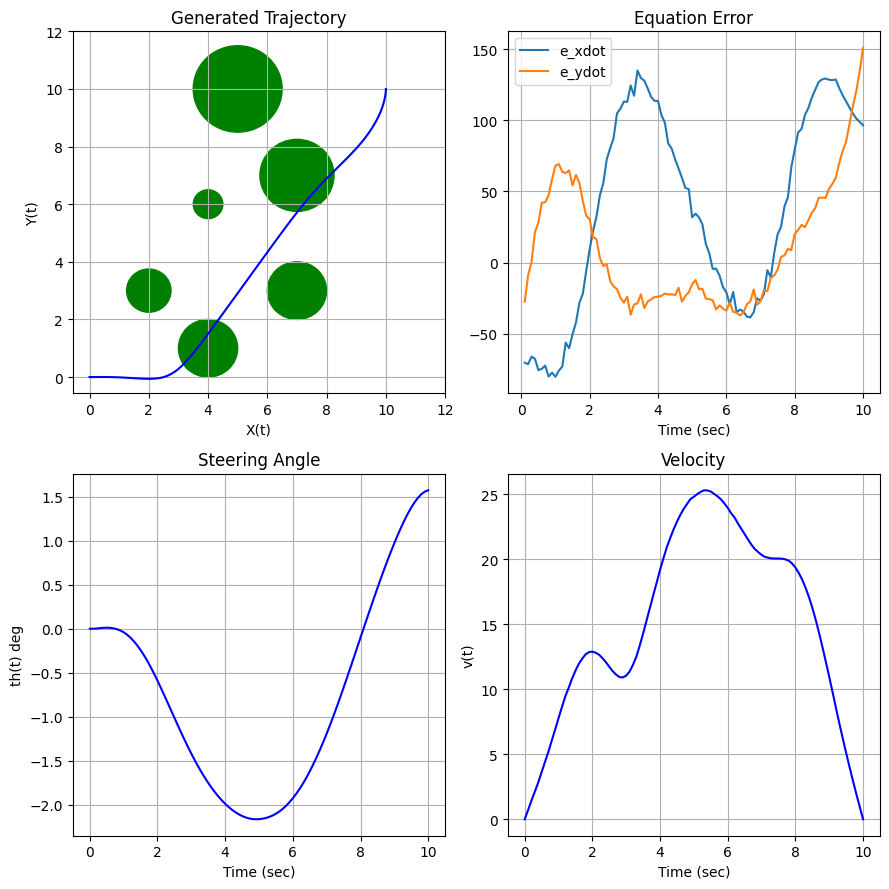

In [ ]:
# Define number of segments and basis functions
num_segments = 100
num_basis_functions = 3

start_time = time.time()

# Generate basis functions for each segment
basis_functions = [radial_basis_functions(i * (1.0 / num_segments), num_basis_functions) for i in range(num_segments)]

# Flatten the basis functions into a single vector for optimization
basis_functions_flat = np.concatenate(basis_functions)

# Initial guess for control trajectories
initial_guess = np.random.randn(num_segments * 2)

# Set up optimization problem with constraints
args = (initial_state, final_state, num_segments, basis_functions_flat, obstacles)
constraints = [{'type': 'eq', 'fun': final_state_constraint, 'args': args}]
result = minimize(cost_function, initial_guess, args=args, method='SLSQP', constraints=constraints)

# Extract optimal control trajectories from the result
optimal_control_traj = result.x.reshape(num_segments, 2)

end_time = time.time()
runtime = end_time - start_time
print("Runtime: {:.5f} seconds".format(runtime))

# Simulate trajectory using optimal control trajectory
simulated_states = simulate_trajectory(initial_state, optimal_control_traj, num_segments)

# Extract variables for plotting
X = simulated_states[:, 0]
Y = simulated_states[:, 1]
theta = simulated_states[:, 2]
xdot = simulated_states[:, 3]
ydot = simulated_states[:, 4]
theta_dot = simulated_states[:, 5]

# Time array
time_plot = np.linspace(0, 10, num_segments + 1)

# Plotting
plt.figure(figsize=(9, 9))

# 1. Plot trajectory Y(t) versus X(t)
plt.subplot(2, 2, 1)
plt.plot(X, Y, '-b')
plt.xlabel('X(t)')
plt.ylabel('Y(t)')
plt.title('Generated Trajectory')
minobs = 1000
maxobs = 0
for obstacle in obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='green')
    plt.gca().add_patch(circle)
    if obstacle[0]-obstacle[2] < minobs:
      minobs = obstacle[0]-obstacle[2]
    elif obstacle[1]-obstacle[2] < minobs:
      minobs = obstacle[1]-obstacle[2]
    if obstacle[0]+obstacle[2] > maxobs:
      maxobs = obstacle[0]+obstacle[2]
    elif obstacle[1]+obstacle[2] > maxobs:
      maxobs = obstacle[1]+obstacle[2]
minlist = [min(X),min(Y),minobs]
maxlist = [max(X),max(Y),maxobs]
plt.xlim(min(minlist)-.5, max(maxlist)+.5)
plt.ylim(min(minlist)-.5, max(maxlist)+.5)
plt.grid(True)

# 2. Plot equation error xdot as a function of time
plt.subplot(2, 2, 2)
plt.plot(time_plot[1:], xdot[1:] - optimal_control_traj[:, 0], label = 'e_xdot')
plt.plot(time_plot[1:], ydot[1:] - optimal_control_traj[:, 1], label = 'e_ydot')
plt.xlabel('Time (sec)')
plt.title('Equation Error')
plt.legend()
plt.grid(True)

# 3. Plot steering angle theta as a function of time
plt.subplot(2, 2, 3)
plt.plot(time_plot, theta, '-b')
plt.xlabel('Time (sec)')
plt.ylabel('th(t) deg')
plt.title('Steering Angle')
plt.grid(True)

# 4. Plot velocity as a function of time
plt.subplot(2, 2, 4)
plt.plot(time_plot, np.sqrt(xdot**2 + ydot**2), '-b')
plt.xlabel('Time (sec)')
plt.ylabel('v(t)')
plt.title('Velocity')
plt.grid(True)

plt.tight_layout()
plt.show()


###Radial Solution - 5 Basis Functions

Runtime: 66.89740 seconds


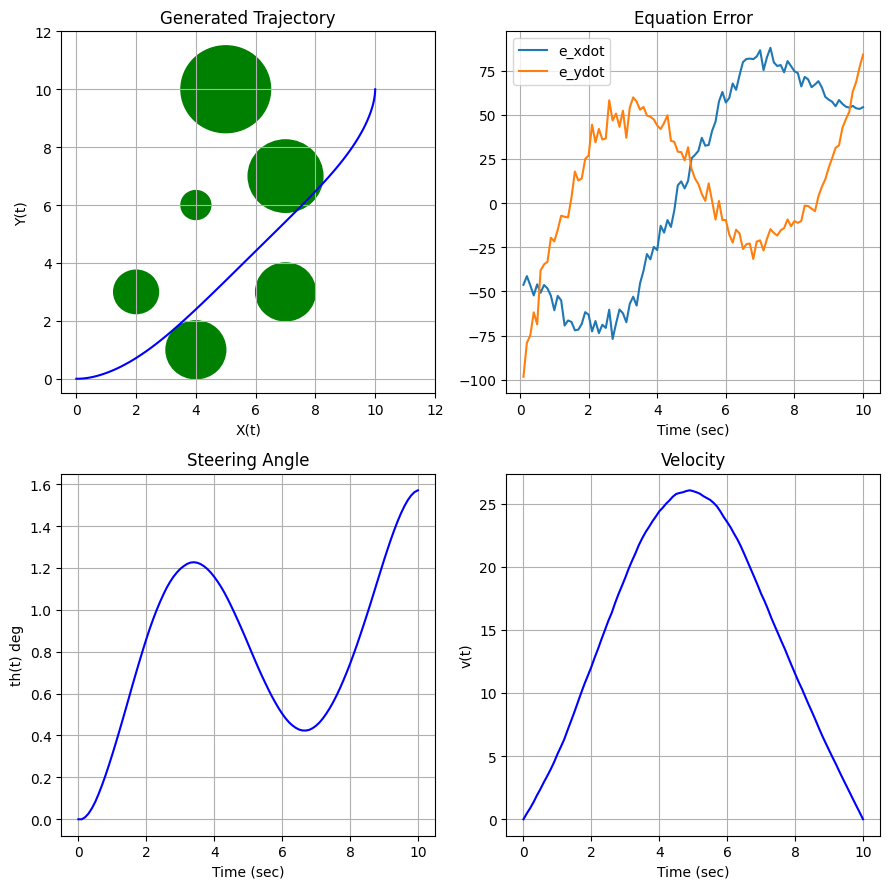

In [ ]:
# Define number of segments and basis functions
num_segments = 100
num_basis_functions = 5

start_time = time.time()

# Generate basis functions for each segment
basis_functions = [radial_basis_functions(i * (1.0 / num_segments), num_basis_functions) for i in range(num_segments)]

# Flatten the basis functions into a single vector for optimization
basis_functions_flat = np.concatenate(basis_functions)

# Initial guess for control trajectories
initial_guess = np.random.randn(num_segments * 2)

# Set up optimization problem with constraints
args = (initial_state, final_state, num_segments, basis_functions_flat, obstacles)
constraints = [{'type': 'eq', 'fun': final_state_constraint, 'args': args}]
result = minimize(cost_function, initial_guess, args=args, method='SLSQP', constraints=constraints)

# Extract optimal control trajectories from the result
optimal_control_traj = result.x.reshape(num_segments, 2)

end_time = time.time()
runtime = end_time - start_time
print("Runtime: {:.5f} seconds".format(runtime))

# Simulate trajectory using optimal control trajectory
simulated_states = simulate_trajectory(initial_state, optimal_control_traj, num_segments)

# Extract variables for plotting
X = simulated_states[:, 0]
Y = simulated_states[:, 1]
theta = simulated_states[:, 2]
xdot = simulated_states[:, 3]
ydot = simulated_states[:, 4]
theta_dot = simulated_states[:, 5]

# Time array
time_plot = np.linspace(0, 10, num_segments + 1)

# Plotting
plt.figure(figsize=(9, 9))

# 1. Plot trajectory Y(t) versus X(t)
plt.subplot(2, 2, 1)
plt.plot(X, Y, '-b')
plt.xlabel('X(t)')
plt.ylabel('Y(t)')
plt.title('Generated Trajectory')
minobs = 1000
maxobs = 0
for obstacle in obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='green')
    plt.gca().add_patch(circle)
    if obstacle[0]-obstacle[2] < minobs:
      minobs = obstacle[0]-obstacle[2]
    elif obstacle[1]-obstacle[2] < minobs:
      minobs = obstacle[1]-obstacle[2]
    if obstacle[0]+obstacle[2] > maxobs:
      maxobs = obstacle[0]+obstacle[2]
    elif obstacle[1]+obstacle[2] > maxobs:
      maxobs = obstacle[1]+obstacle[2]
minlist = [min(X),min(Y),minobs]
maxlist = [max(X),max(Y),maxobs]
plt.xlim(min(minlist)-.5, max(maxlist)+.5)
plt.ylim(min(minlist)-.5, max(maxlist)+.5)
plt.grid(True)

# 2. Plot equation error xdot as a function of time
plt.subplot(2, 2, 2)
plt.plot(time_plot[1:], xdot[1:] - optimal_control_traj[:, 0], label = 'e_xdot')
plt.plot(time_plot[1:], ydot[1:] - optimal_control_traj[:, 1], label = 'e_ydot')
plt.xlabel('Time (sec)')
plt.title('Equation Error')
plt.legend()
plt.grid(True)

# 3. Plot steering angle theta as a function of time
plt.subplot(2, 2, 3)
plt.plot(time_plot, theta, '-b')
plt.xlabel('Time (sec)')
plt.ylabel('th(t) deg')
plt.title('Steering Angle')
plt.grid(True)

# 4. Plot velocity as a function of time
plt.subplot(2, 2, 4)
plt.plot(time_plot, np.sqrt(xdot**2 + ydot**2), '-b')
plt.xlabel('Time (sec)')
plt.ylabel('v(t)')
plt.title('Velocity')
plt.grid(True)

plt.tight_layout()
plt.show()


##Approach 2 - Neural Networks

###Trajectories Modeled as Neural Networks

In [ ]:
# Design the neural network
def createTraj():
    fhat = Sequential()
    fhat.add(Dense(50, activation="sigmoid", input_dim=1))
    fhat.add(Dense(1))
    return fhat

x = createTraj()
y = createTraj()
v = createTraj()
th = createTraj()

###Compute Loss Function

In [ ]:
T0 = 0
Tf = 1
nPts = 20
T = tf.cast(tf.linspace(0,Tf,nPts),dtype=tf.float32)

def errors(t, obstacles=[]):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        X = x(t)
        Y = y(t)

    Xd = tape.gradient(X, t)
    Yd = tape.gradient(Y, t)

    TH = th(t)
    V  = v(t)

    # Error in dynamics
    e_xdot = tf.reduce_sum((tf.reshape(Xd, shape=(nPts, 1)) - V * tf.cos(TH))**2)
    e_ydot = tf.reduce_sum((tf.reshape(Yd, shape=(nPts, 1)) - V * tf.sin(TH))**2)

    # Error in initial condition
    x0 = 0
    y0 = 0
    eIC = (X[0] - x0)**2 + (Y[0] - y0)**2 + TH[0]**2 + V[0]**2  # start from (x0, y0) at rest and pointing east

    # Error in final condition
    xf = 10
    yf = 10
    eFC = (X[-1] - xf)**2 + (Y[-1] - yf)**2 + (TH[-1] - 3.141)**2 + V[-1]**2  # end at (xf, yf) at rest and pointing west

    # Error in obstacle avoidance
    e_obstacles = 0
    for obstacle in obstacles:
        # Compute the squared distance from each point on the trajectory to the center of the obstacle
        dist_squared = (X - obstacle[0])**2 + (Y - obstacle[1])**2
        # Compute the sum of the radii of the trajectory and the obstacle
        combined_radius_squared = (obstacle[2] + 0.5)**2  # Adjusted to account for the size of the trajectory
        # Check if any point on the trajectory is too close to the obstacle
        too_close = dist_squared - combined_radius_squared
        # If any point is too close, add penalty to the error
        for j in range(len(too_close)):
          if too_close[j] < 0:
            e_obstacles += -1*too_close[j]

    return e_xdot + e_ydot + 100 * eIC + 100 * eFC + 100*e_obstacles



###Train the Network

In [ ]:
nIter = 1001

start_time = time.time()  # Get the current time before running the code

# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
for i in range(nIter):
    with tf.GradientTape(persistent=True) as tape:
        e = errors(T,obstacles)
    if i%50 == 0:
        print(f'iter: {i}, error: {e}')

    # Update parameters in x
    grads = tape.gradient(e, x.trainable_variables)
    optimizer.apply_gradients(zip(grads, x.trainable_variables))

    # Update parameters in y
    grads = tape.gradient(e, y.trainable_variables)
    optimizer.apply_gradients(zip(grads, y.trainable_variables))

    # Update parameters in v
    grads = tape.gradient(e, v.trainable_variables)
    optimizer.apply_gradients(zip(grads, v.trainable_variables))

    # Update parameters in th
    grads = tape.gradient(e, th.trainable_variables)
    optimizer.apply_gradients(zip(grads, th.trainable_variables))

end_time = time.time()
runtime = end_time - start_time
print("Runtime: {:.5f} seconds".format(runtime))

iter: 0, error: [17830.547]
iter: 50, error: [3836.0767]
iter: 100, error: [3343.2659]
iter: 150, error: [1341.8845]
iter: 200, error: [585.87994]
iter: 250, error: [356.179]
iter: 300, error: [415.36777]
iter: 350, error: [287.18823]
iter: 400, error: [202.40369]
iter: 450, error: [376.81293]
iter: 500, error: [290.10327]
iter: 550, error: [112.03398]
iter: 600, error: [115.11287]
iter: 650, error: [72.158714]
iter: 700, error: [202.60574]
iter: 750, error: [68.962944]
iter: 800, error: [75.79016]
iter: 850, error: [45.669266]
iter: 900, error: [53.869648]
iter: 950, error: [273.43094]
iter: 1000, error: [36.95771]
Runtime: 137.74887 seconds


###Plot the Results

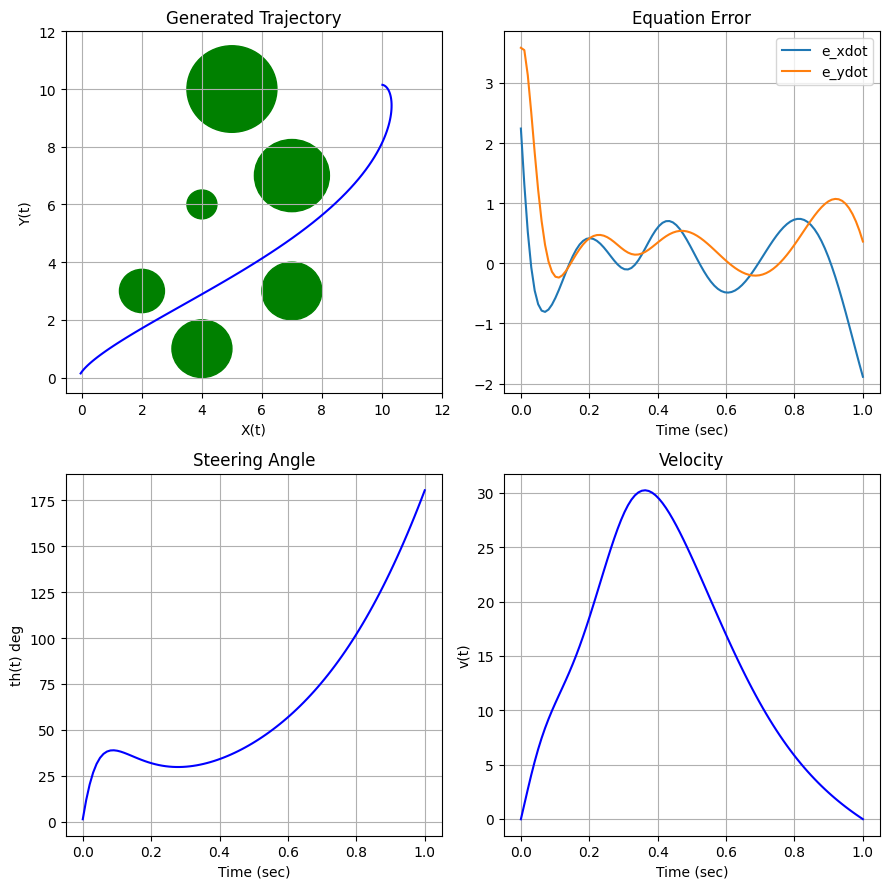

In [ ]:
# Define the number of points for plotting
nPts1 = 100
TT = tf.cast(tf.linspace(0, Tf, nPts1), dtype=tf.float32)
tt = TT.numpy()

# Create a GradientTape to compute gradients
with tf.GradientTape(persistent=True) as tape:
    tape.watch(TT)
    X = x(TT)
    Y = y(TT)

# Compute the gradients of X and Y
Xd = tape.gradient(X, TT)
Yd = tape.gradient(Y, TT)

# Compute the equation errors
e_xdot = tf.reshape(Xd, shape=(nPts1, 1)) - v(TT) * tf.cos(th(TT))
e_ydot = tf.reshape(Yd, shape=(nPts1, 1)) - v(TT) * tf.sin(th(TT))

# Define the conversion factor from radians to degrees
r2d = 180/np.pi

# Create the plot
plt.figure(figsize=(9, 9))

# Plot the trajectory
plt.subplot(2, 2, 1)
plt.plot(X.numpy(), Y.numpy(), '-b')
plt.xlabel('X(t)')
plt.ylabel('Y(t)')
plt.title('Generated Trajectory')
plt.grid(True)

minobs = 1000
maxobs = 0
# Plot the obstacles
for obstacle in obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='green', fill=True)
    plt.gca().add_patch(circle)
    if obstacle[0]-obstacle[2] < minobs:
      minobs = obstacle[0]-obstacle[2]
    elif obstacle[1]-obstacle[2] < minobs:
      minobs = obstacle[1]-obstacle[2]
    if obstacle[0]+obstacle[2] > maxobs:
      maxobs = obstacle[0]+obstacle[2]
    elif obstacle[1]+obstacle[2] > maxobs:
      maxobs = obstacle[1]+obstacle[2]
minlist = [min(X.numpy()),min(Y.numpy()),minobs]
maxlist = [max(X.numpy()),max(Y.numpy()),maxobs]
plt.xlim(min(minlist)-.5, max(maxlist)+.5)
plt.ylim(min(minlist)-.5, max(maxlist)+.5)

# Plot the equation error
plt.subplot(2, 2, 2)
plt.plot(tt, e_xdot, label='e_xdot')
plt.plot(tt, e_ydot, label='e_ydot')
plt.xlabel('Time (sec)')
plt.title('Equation Error')
plt.grid(True)
plt.legend()

# Plot the steering angle
plt.subplot(2, 2, 3)
plt.plot(tt, th(TT).numpy() * r2d, '-b')
plt.xlabel('Time (sec)')
plt.ylabel('th(t) deg')
plt.title('Steering Angle')
plt.grid(True)

# Plot the velocity
plt.subplot(2, 2, 4)
plt.plot(tt, v(TT).numpy(), '-b')
plt.xlabel('Time (sec)')
plt.ylabel('v(t)')
plt.title('Velocity')
plt.grid(True)

plt.tight_layout()
plt.show()

##Comparison/Analsis

**Approach 1 Solution Quality:** The quality of the solution with the linear combination of basis functions highly depends on the location of the obstacles. For certain obstacle locations, approach 1 cannot get a solution. In other cases, only the radial could get a solution while polynomial or BSpline failed. It almost always came to a better solution with increasing basis functions though. Therefore, if you could determine what type of basis functions would solve the problem the best for a particular set of obstacle locations and you utilized a high number of basis functions you can get a high quality solution, but in every case I tried the Neural Network provided a better and more smooth solution. For the obstacle placements of my final code only the 5 polynomial, 3 BSpline, and 5 radial basis functions came to good solutions (and even those were not perfect). I think with more iterations that could provide good solutions, but overall the neural network solutions were far more robust.

**Approach 1 Runtime:** The runtime for approach 1 was approximately a minute no matter which basis function type or even the number of basis functions (I was shocked by this, in fact many cases the 5 basis functions were quicker than the 3). However, this is only with 100 iterations, the stock for scipy.optimize.minimize. Therefore, it is actually slower per iteration than the neural network solution.

**Approach 2 Solution Quality:** The neural network solution always provided an accurate answer no matter where the obstacles were placed. Furthermore, the errors plotted by the neural network code are drastically less than that of the basis functions, the increase of iterations also helps with this but the majority comes from it being a better solution technique. Sometimes if the obstacles were placed in difficult locations it would opt to just completely go around them, but the code never hit an obstacle any of the times I ran, which cannot be said for the less accurate technique used in approach 1.

**Approach 2 Runtime:** The neural network code takes approximately two minutes to run through all 1000 iterations, which is much faster than approach 1.

